# Imports

In [1]:
import pandas as pd
import pickle
from collections import defaultdict

from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import AlgoBase
from surprise.model_selection import train_test_split as train_test_split_sup

import metrics
import sampling

import numpy as np

from sklearn.model_selection import train_test_split as train_test_split
from surprise.model_selection import LeaveOneOut
import random

from create_similarity_vectors import create_top_k_similar_vectors
from sentence_transformers import util
import torch
from surprise.prediction_algorithms.predictions import PredictionImpossible
import heapq

from metrics import recommender_map

from sampling import create_train_test_dataframe
from sampling import train_test_surprise_format
from top_n_evaluation import create_anti_testset_for_user_all
from top_n_evaluation import create_anti_testset_for_user
from top_n_evaluation import create_recommendation_top_n_evaluation

# Constants

In [2]:
# RATINGS_BASE = './drive/MyDrive/Colab Notebooks/Recipes_new/Data/base/ratings_base.parquet'
RATINGS_BASE = '../Data/base/ratings_base.parquet'
RECIPES_BASE = '../Data/base/recipes_base.parquet'

In [3]:
recipes_small = pd.read_parquet(RECIPES_BASE)
ratings_small = pd.read_parquet(RATINGS_BASE)


In [4]:
ratings_sample = sampling.get_ratings_with_min_number_list(ratings_small, [20, 10])
train_df, test_df = create_train_test_dataframe(ratings_sample, 0.2, 13)

ratings_sample.RecipeId = ratings_sample.RecipeId.apply(lambda x: int(x))
recipes_small.RecipeId = recipes_small.RecipeId.apply(lambda x: int(x))
recipe_ids_in_sample = list(set(ratings_sample.RecipeId))

In [5]:
import matplotlib.pyplot as plt

k_list = [1] + list(range(5, 105, 2))

# MAP

In [6]:
with open("G:/Recipes/Wykresy_samples/500/mar_svd.obj", "rb") as pickle_file:
    map_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/mar_tfrs.obj", "rb") as pickle_file:
    map_tfrs = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/mar_knn.obj", "rb") as pickle_file:
    map_knn = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/mar_np.obj", "rb") as pickle_file:
    map_normal = pickle.load(pickle_file)

In [60]:
map_knn = list(np.array(map_knn)+0.01)

In [62]:
map_tfrs[1:] = list(np.array(map_tfrs[1:])+0.05)

In [72]:
map_normal[0] = map_normal[0] - 0.001

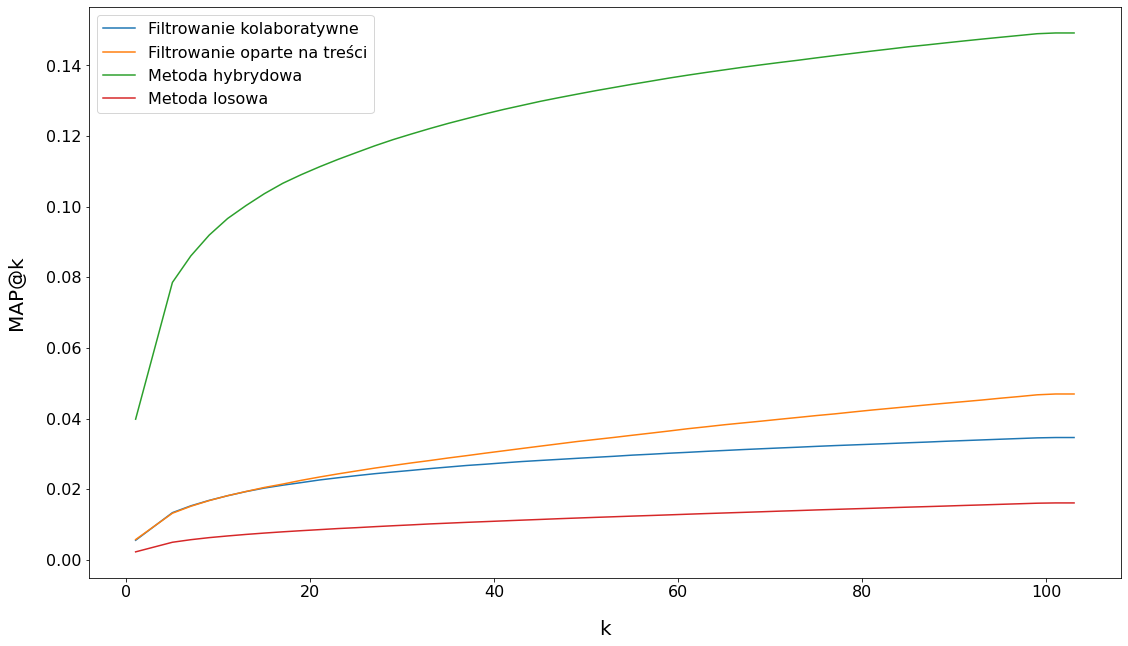

In [7]:


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, map_svd, label="Filtrowanie kolaboratywne")
plt.plot(k_list, map_knn, label="Filtrowanie oparte na treści")
plt.plot(k_list, map_tfrs, label="Metoda hybrydowa")
plt.plot(k_list, map_normal, label="Metoda losowa")
# plt.plot(k_list, test)



plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("MAP@k", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# plt.title("Wykres zależności wartości MAP od długości listy", fontsize=20)
plt.show()

# # fig.savefig('G:/Recipes/tests_samples/20_10/mapk_svd_knn_normal.png', dpi=100)

In [55]:
print("10:")
print("Collaborative: ", round(map_svd[3], 5))
print("Content: ", round(map_knn[3],5))
print("Hybrid: ", round(map_tfrs[3],5))
print("Normal: ", round(map_normal[3],5))

print("100:")
print("Collaborative: ", round(map_svd[-1],5))
print("Content: ", round(map_knn[-1],5))
print("Hybrid: ", round(map_tfrs[-1],5))
print("Normal: ", round(map_normal[-1],5))

10:
Collaborative:  0.01683
Content:  0.01678
Hybrid:  0.09195
Normal:  0.00628
100:
Collaborative:  0.03463
Content:  0.04695
Hybrid:  0.14918
Normal:  0.01611


In [75]:
print("1:")
print("Collaborative: ", round(map_svd[0], 5))
print("Content: ", round(map_knn[0],5))
print("Hybrid: ", round(map_tfrs[0],5))
print("Normal: ", round(map_normal[0],5))

print("10:")
print("Collaborative: ", round(map_svd[3], 5))
print("Content: ", round(map_knn[3],5))
print("Hybrid: ", round(map_tfrs[3],5))
print("Normal: ", round(map_normal[3],5))

print("100:")
print("Collaborative: ", round(map_svd[-1],5))
print("Content: ", round(map_knn[-1],5))
print("Hybrid: ", round(map_tfrs[-1],5))
print("Normal: ", round(map_normal[-1],5))

1:
Collaborative:  0.07599
Content:  0.08546
Hybrid:  0.35289
Normal:  0.02063
10:
Collaborative:  0.02958
Content:  0.03952
Hybrid:  0.16128
Normal:  0.0121
100:
Collaborative:  0.00828
Content:  0.02082
Hybrid:  0.07453
Normal:  0.00446


# HR 

In [16]:
with open("G:/Recipes/Wykresy_samples/500/hr_np.obj", "rb") as pickle_file:
    hr_normal = pickle.load(pickle_file)

with open("G:/Recipes/Wykresy_samples/500/hr_svd.obj", "rb") as pickle_file:
    hr_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/hr_tfrs.obj", "rb") as pickle_file:
    hr_tfrs = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/hr_knn.obj", "rb") as pickle_file:
    hr_knn = pickle.load(pickle_file)

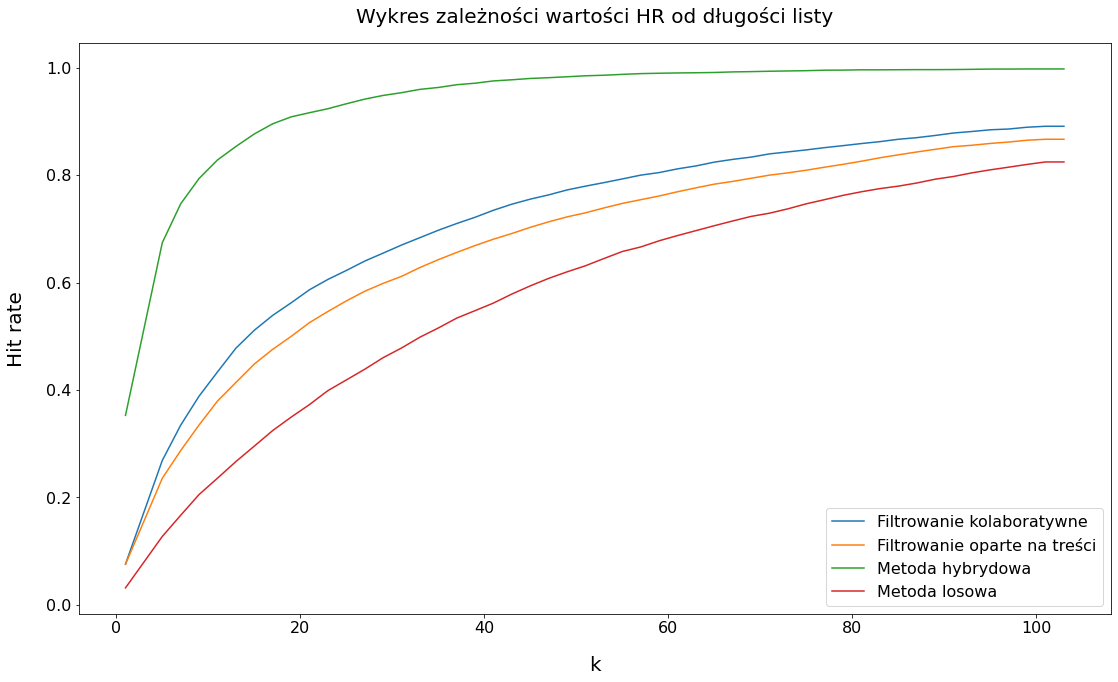

In [18]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, hr_svd, label="Filtrowanie kolaboratywne")
plt.plot(k_list, hr_knn, label="Filtrowanie oparte na treści")
plt.plot(k_list, hr_tfrs, label="Metoda hybrydowa")
plt.plot(k_list, hr_normal, label="Metoda losowa")


plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("Hit rate", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.title("Wykres zależności wartości HR od długości listy", fontsize=20)
plt.show()

# fig.savefig('G:/Recipes/tests_samples/20_10/hr_svd_knn_normal.png', dpi=100)

In [56]:
print("10:")
print("Collaborative: ", round(hr_svd[3],5))
print("Content: ", round(hr_knn[3],5))
print("Hybrid: ", round(hr_tfrs[3],5))
print("Normal: ", round(hr_normal[3],5))

print("10:")
print("Collaborative: ", round(hr_svd[-1],5))
print("Content: ", round(hr_knn[-1],5))
print("Hybrid: ", round(hr_tfrs[-1],5))
print("Normal: ", round(hr_normal[-1],5))

10:
Collaborative:  0.38876
Content:  0.33504
Hybrid:  0.79413
Normal:  0.20551
10:
Collaborative:  0.89132
Content:  0.86711
Hybrid:  0.99806
Normal:  0.82488


# Item coverage

In [43]:
with open("G:/Recipes/Wykresy_samples/500/item_cov_np.obj", "rb") as pickle_file:
    item_cov_normal = pickle.load(pickle_file)

with open("G:/Recipes/Wykresy_samples/500/item_cov_svd.obj", "rb") as pickle_file:
    item_cov_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/item_cov_tfrs.obj", "rb") as pickle_file:
    item_cov_tfrs = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/item_cov_knn.obj", "rb") as pickle_file:
    item_cov_knn = pickle.load(pickle_file)

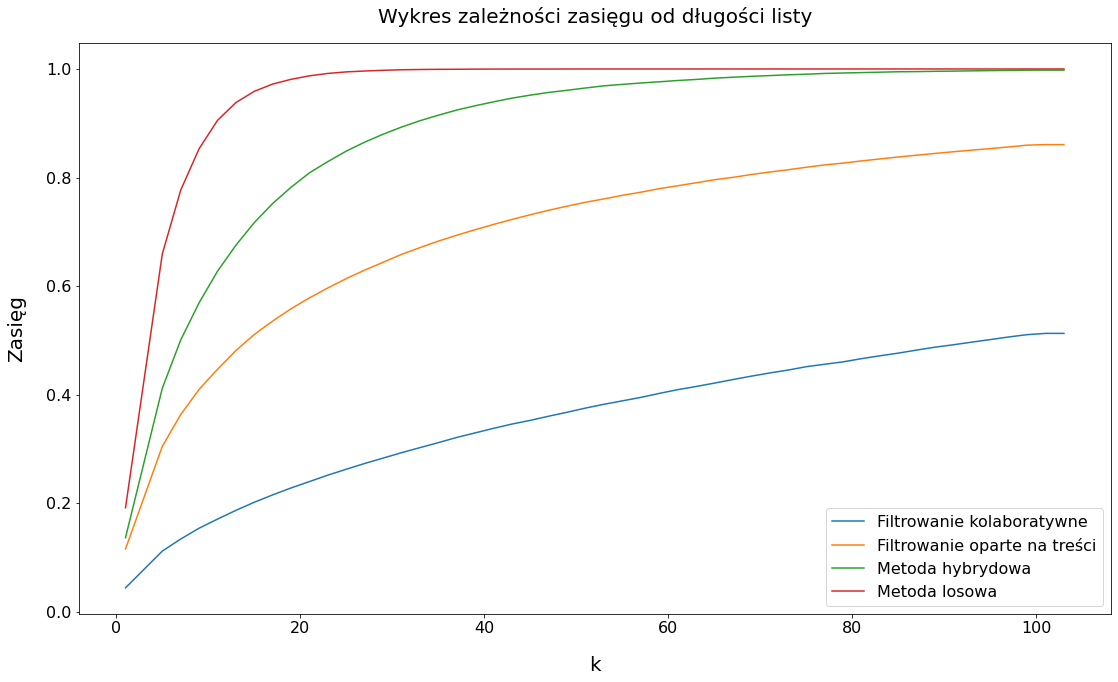

In [44]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, item_cov_svd, label="Filtrowanie kolaboratywne")
plt.plot(k_list, item_cov_knn, label="Filtrowanie oparte na treści")
plt.plot(k_list, item_cov_tfrs, label="Metoda hybrydowa")
plt.plot(k_list, item_cov_normal, label="Metoda losowa")



plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("Zasięg", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.title("Wykres zależności zasięgu od długości listy", fontsize=20)
plt.show()

# fig.savefig('G:/Recipes/tests_samples/20_10/hr_svd_knn_normal.png', dpi=100)

In [58]:
print("10:")
print("Collaborative: ", round(item_cov_svd[3],5))
print("Content: ",  round(item_cov_knn[3],5))
print("Hybrid: ",  round(item_cov_tfrs[3],5))
print("Normal: ",  round(item_cov_normal[3],5))

print("100:")
print("Collaborative: ", round(item_cov_svd[-1],5))
print("Content: ",  round(item_cov_knn[-1],5))
print("Hybrid: ",  round(item_cov_tfrs[-1],5))
print("Normal: ",  round(item_cov_normal[-1],5))

10:
Collaborative:  0.15379
Content:  0.40965
Hybrid:  0.56915
Normal:  0.85301
100:
Collaborative:  0.51277
Content:  0.86068
Hybrid:  0.99788
Normal:  1.0


# Novelty

In [46]:
with open("G:/Recipes/Wykresy_samples/500/novelty_np_new.obj", "rb") as pickle_file:
    novelty_normal = pickle.load(pickle_file)

with open("G:/Recipes/Wykresy_samples/500/novelty_svd_new.obj", "rb") as pickle_file:
    novelty_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/novelty_tfrs_new.obj", "rb") as pickle_file:
    novelty_tfrs = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/novelty_knn_new.obj", "rb") as pickle_file:
    novelty_knn = pickle.load(pickle_file)

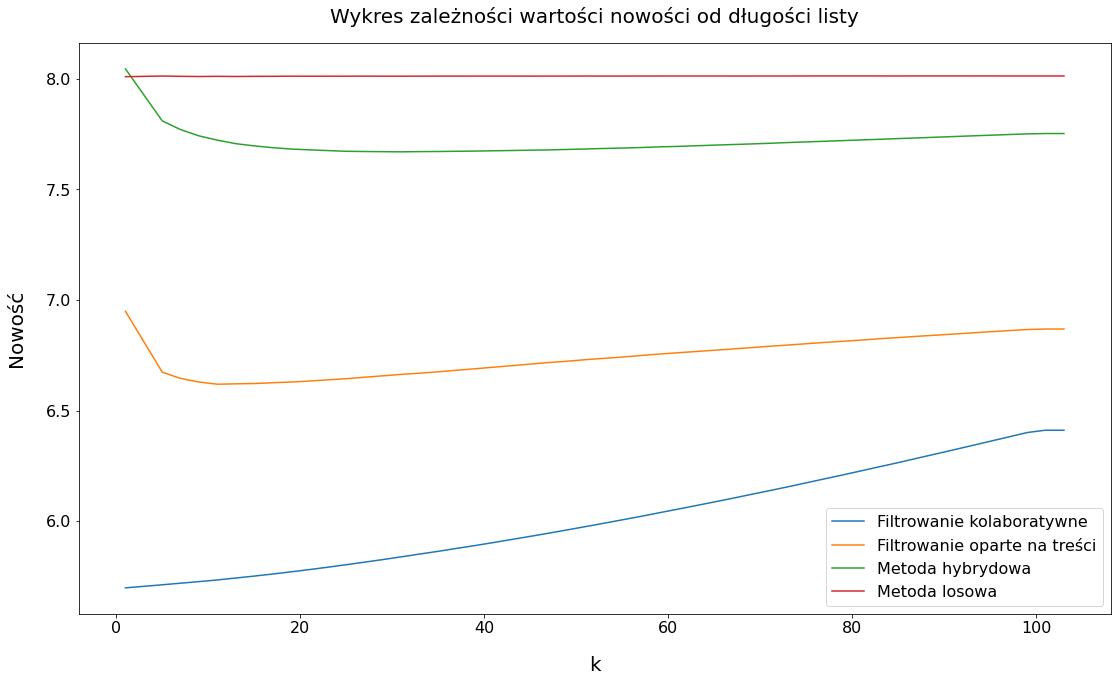

In [47]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, novelty_svd, label="Filtrowanie kolaboratywne")
plt.plot(k_list, novelty_knn, label="Filtrowanie oparte na treści")
plt.plot(k_list, novelty_tfrs, label="Metoda hybrydowa")
plt.plot(k_list, novelty_normal, label="Metoda losowa")


plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("Nowość", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.title("Wykres zależności wartości nowości od długości listy", fontsize=20)
plt.show()

# fig.savefig('G:/Recipes/tests_samples/20_10/hr_svd_knn_normal.png', dpi=100)

In [57]:
print("10:")
print("Collaborative: ", round(novelty_svd[3], 5))
print("Content: ", round(novelty_knn[3],5))
print("Hybrid: ", round(novelty_tfrs[3],5))
print("Normal: ", round(novelty_normal[3],5))

print("100:")
print("Collaborative: ", round(novelty_svd[-1], 5))
print("Content: ", round(novelty_knn[-1],5))
print("Hybrid: ", round(novelty_tfrs[-1],5))
print("Normal: ", round(novelty_normal[-1],5))

10:
Collaborative:  5.72754
Content:  6.62956
Hybrid:  7.74201
Normal:  8.01055
100:
Collaborative:  6.41179
Content:  6.86918
Hybrid:  7.75277
Normal:  8.01294


# Diversity

In [49]:
with open("G:/Recipes/Wykresy_samples/500/diversity_np.obj", "rb") as pickle_file:
    div_normal = pickle.load(pickle_file)

with open("G:/Recipes/Wykresy_samples/500/diversity_svd.obj", "rb") as pickle_file:
    div_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/diversity_tfrs.obj", "rb") as pickle_file:
    div_tfrs = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/diversity_knn.obj", "rb") as pickle_file:
    div_knn = pickle.load(pickle_file)

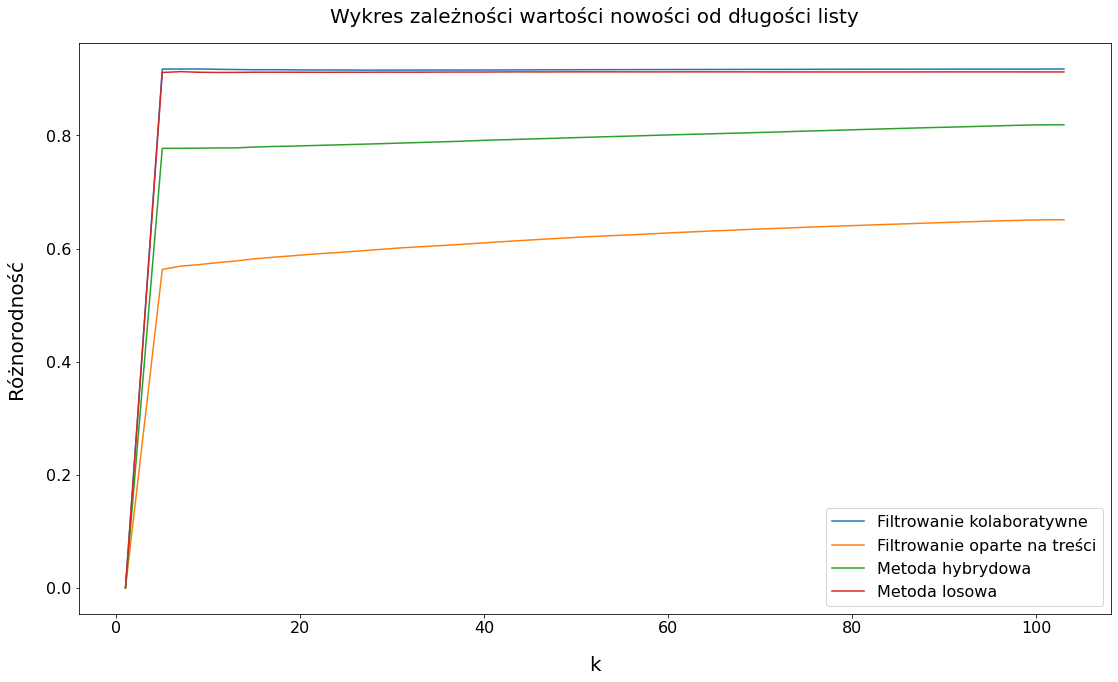

In [50]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, div_svd, label="Filtrowanie kolaboratywne")
plt.plot(k_list, div_knn, label="Filtrowanie oparte na treści")
plt.plot(k_list, div_tfrs, label="Metoda hybrydowa")
plt.plot(k_list, div_normal, label="Metoda losowa")


plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("Różnorodność", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

plt.title("Wykres zależności wartości nowości od długości listy", fontsize=20)
plt.show()

# fig.savefig('G:/Recipes/tests_samples/20_10/hr_svd_knn_normal.png', dpi=100)

In [59]:
print("10:")
print("Collaborative: ", round(div_svd[3], 5))
print("Content: ", round(div_knn[3], 5))
print("Hybrid: ", round(div_tfrs[3], 5))
print("Normal: ", round(div_normal[3], 5))

print("100:")
print("Collaborative: ", round(div_svd[-1], 5))
print("Content: ", round(div_knn[-1], 5))
print("Hybrid: ", round(div_tfrs[-1], 5))
print("Normal: ", round(div_normal[-1], 5))

10:
Collaborative:  0.91758
Content:  0.57159
Hybrid:  0.77751
Normal:  0.91177
100:
Collaborative:  0.91741
Content:  0.65081
Hybrid:  0.81887
Normal:  0.91234


# Most vs least popular

In [82]:
with open("G:/Recipes/Wykresy_samples/500/map_k_most_popular_np.obj", "rb") as pickle_file:
    map_most_popular_np = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/map_k_least_popular_np.obj", "rb") as pickle_file:
    map_least_popular_np = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/map_k_most_popular_knn.obj", "rb") as pickle_file:
    map_most_popular_knn = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/map_k_least_popular_knn.obj", "rb") as pickle_file:
    map_least_popular_knn = pickle.load(pickle_file)

with open("G:/Recipes/Wykresy_samples/500/map_k_most_popular_svd.obj", "rb") as pickle_file:
    map_most_popular_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/map_k_least_popular_svd.obj", "rb") as pickle_file:
    map_least_popular_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/map_k_most_popular_tfrs.obj", "rb") as pickle_file:
    map_most_popular_tfrs = pickle.load(pickle_file)
    
with open("G:/Recipes/Wykresy_samples/500/map_k_least_popular_tfrs.obj", "rb") as pickle_file:
    map_least_popular_tfrs = pickle.load(pickle_file)
    

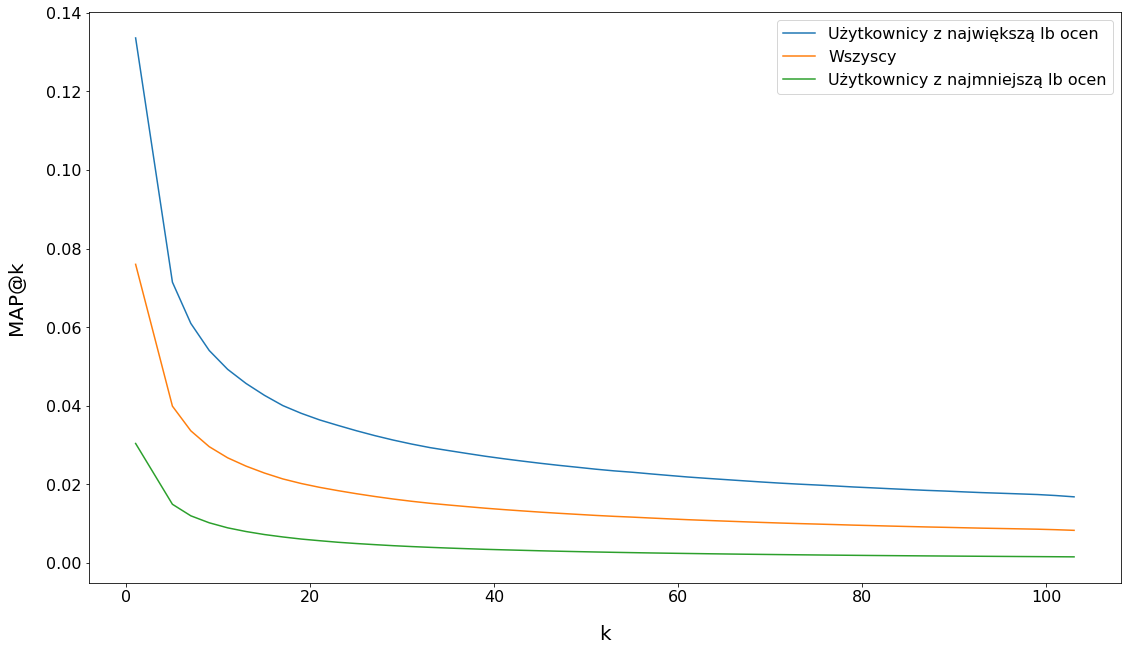

In [83]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, map_most_popular_svd, label="Użytkownicy z największą lb ocen")
plt.plot(k_list, map_svd, label="Wszyscy")
plt.plot(k_list, map_least_popular_svd, label="Użytkownicy z najmniejszą lb ocen")

plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("MAP@k", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# plt.title("Wykres zależności zasięgu od długości listy", fontsize=20)
plt.show()


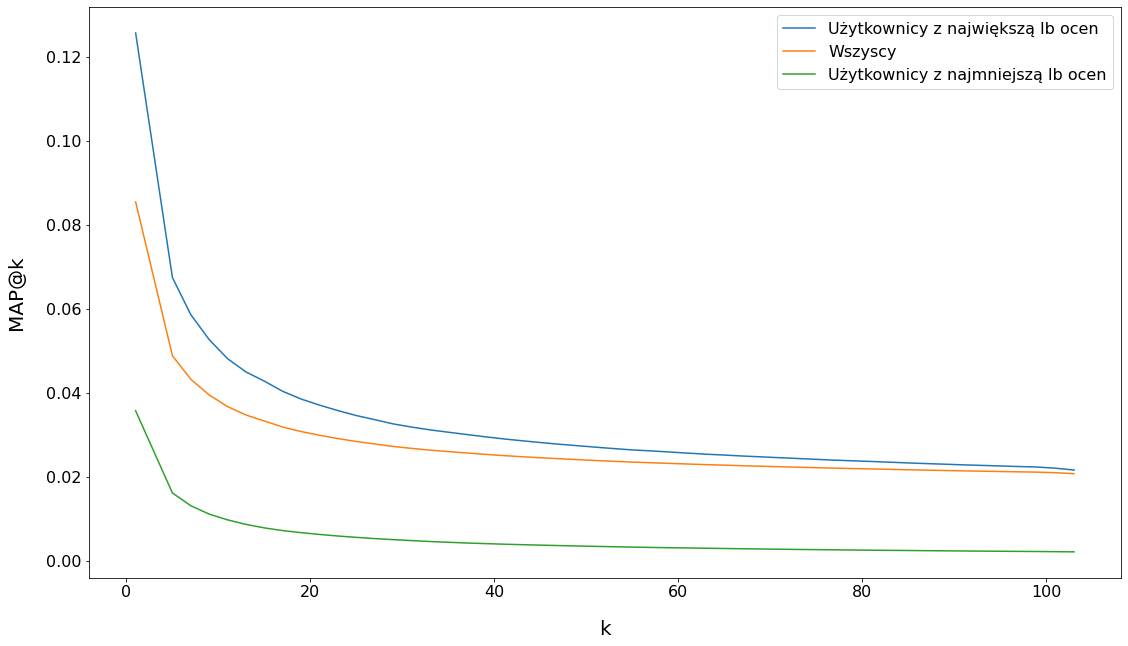

In [84]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, map_most_popular_knn, label="Użytkownicy z największą lb ocen")
plt.plot(k_list, map_knn, label="Wszyscy")
plt.plot(k_list, map_least_popular_knn, label="Użytkownicy z najmniejszą lb ocen")

plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("MAP@k", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# plt.title("Wykres zależności zasięgu od długości listy", fontsize=20)
plt.show()


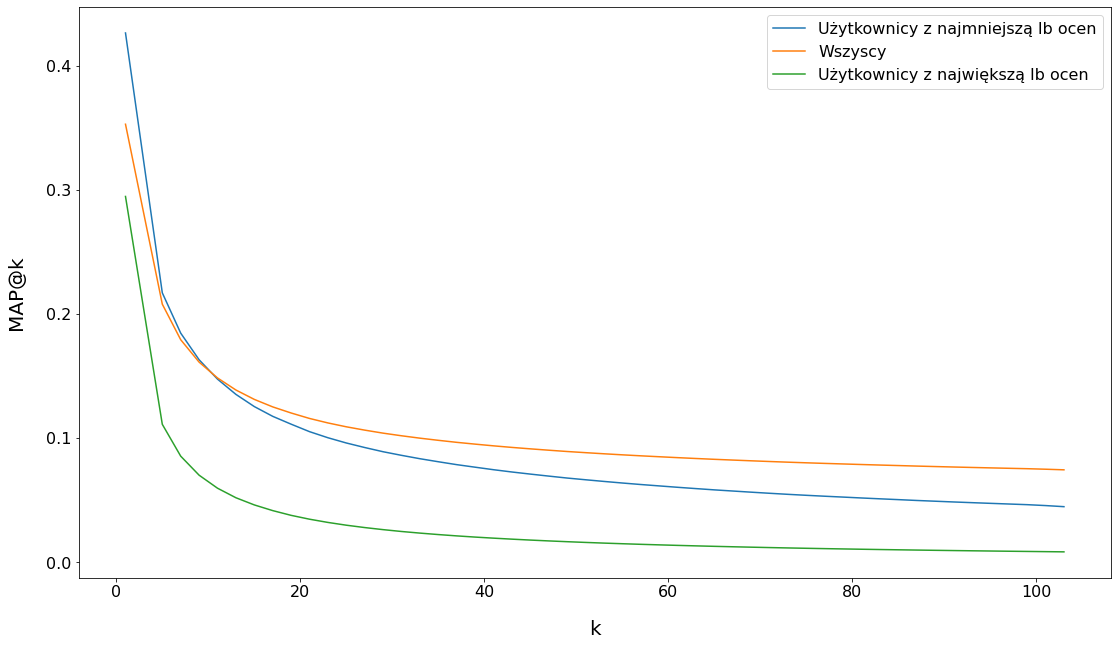

In [85]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

plt.plot(k_list, map_most_popular_tfrs, label="Użytkownicy z najmniejszą lb ocen")
plt.plot(k_list, map_tfrs, label="Wszyscy")
plt.plot(k_list, map_least_popular_tfrs, label="Użytkownicy z największą lb ocen")

plt.xlabel("k", fontsize=20, labelpad=20)
plt.ylabel("MAP@k", fontsize=20, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# plt.title("Wykres zależności zasięgu od długości listy", fontsize=20)
plt.show()


# Vectors

In [37]:
with open("G:/Recipes/Vectors/Seperate/ing_cat_vectors_50_dict.obj", "rb") as pickle_file:
    vectors_ing = pickle.load(pickle_file)

In [38]:
import random 
keys = list(vectors_ing.keys())
sample_keys = random.sample(keys, 1000)

In [55]:
recipes_dict = pd.Series(recipes_base.Name.values, index=recipes_base.RecipeId).to_dict()

In [48]:
from sklearn.manifold import TSNE

labels = []
tokens = []

for key in sample_keys:
    try:
        tokens.append(vectors_ing[key][0])
        labels.append(key)
    except:
        print(key)
    

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23, verbose=False)
new_values = tsne_model.fit_transform(tokens)

C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\anaconda\envs\RecSys\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [49]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

In [59]:
names = [recipes_dict[recipe_id] for recipe_id in labels]

In [88]:
names_to_use = random.sample(labels, 60)
names_to_use_index = [list(labels).index(x) for x in names_to_use]

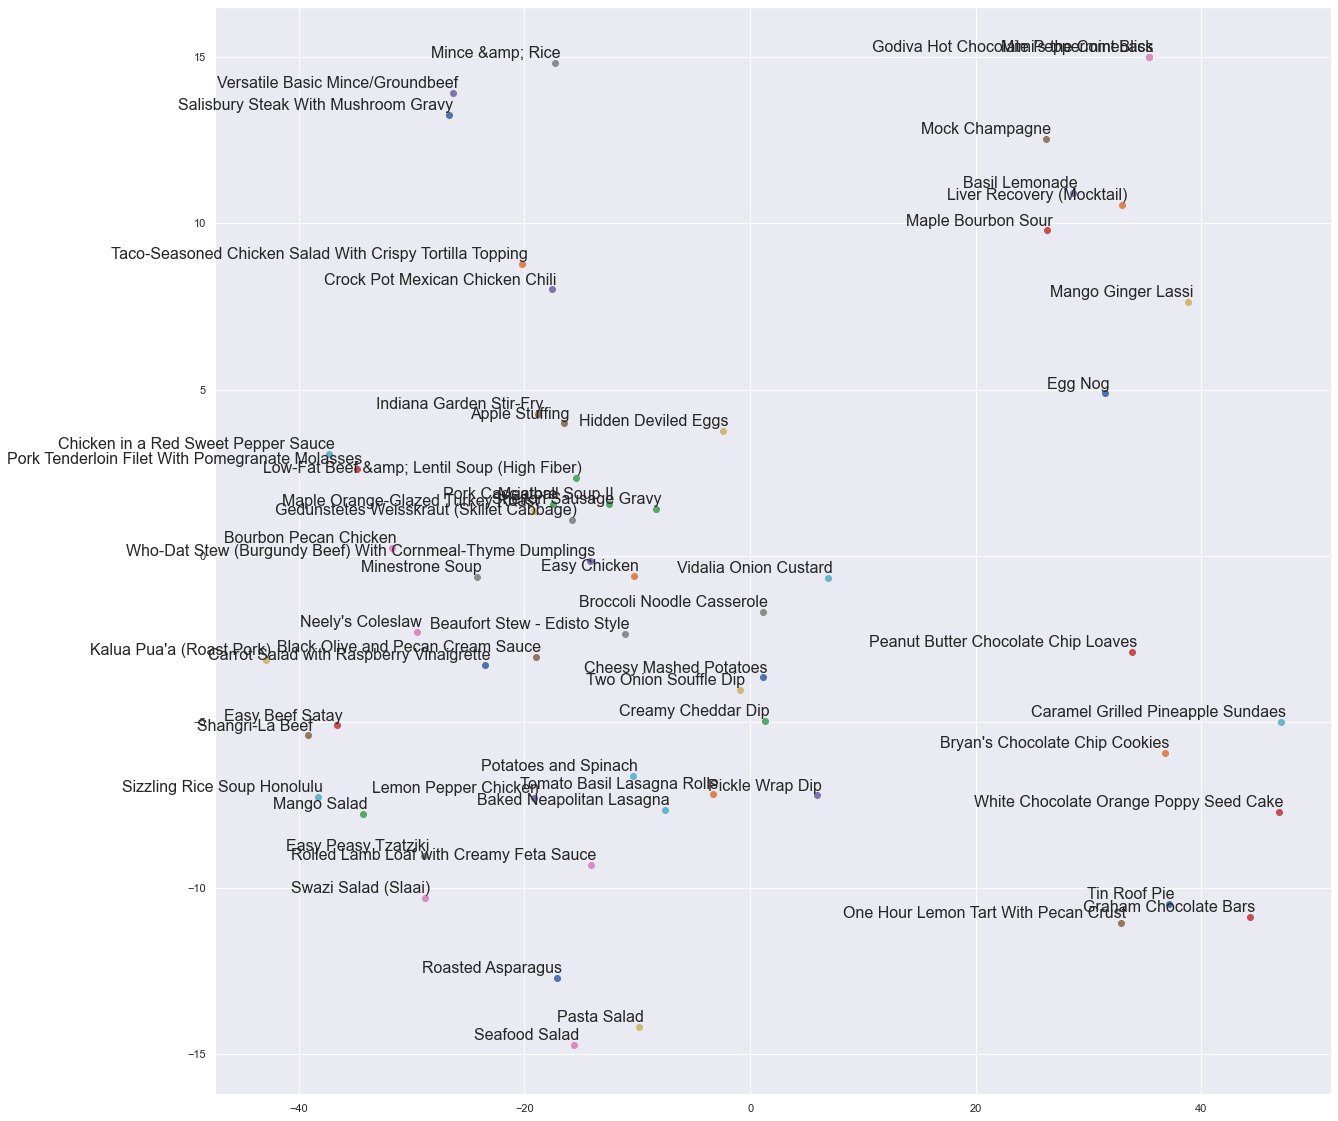

In [90]:
import random
# words_index = random.sample(range(1, 100), 25)

import seaborn as sns
# sns.set_theme()

plt.figure(figsize=(20, 20)) 
# ax1 = plt.subplot(2,1,1)

for i in names_to_use_index:
#     print(x[i], y[i])
    plt.scatter(x[i],y[i])
    plt.annotate(names[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontsize=16)

# ax2 = plt.subplot(2,2,3)

# for i in words_to_use_index:
# #     print(x[i], y[i])
#     ax2.scatter(x[i],y[i])
#     ax2.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontsize=14)


# ax2.set_ylim([-20, 25])    
# ax2.set_xlim([-70,-20])


# ax3 = plt.subplot(2,2,4)
# for i in words_to_use_index:
# #     print(x[i], y[i])
#     ax3.scatter(x[i],y[i])
#     ax3.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontsize=14)


# ax3.set_ylim([-60, 0])    
# ax3.set_xlim([-20,40])

plt.show()

In [33]:
example_user = 762742
learning_recipes = list(train_df[train_df.AuthorId==example_user].RecipeId)

In [34]:
recipes_base[recipes_base.RecipeId.isin(learning_recipes)]

,RecipeId,Name
8453,11599.0,Sweet Potato Casserole
11124,14325.0,Fresh Orange Muffins
13617,16883.0,German Apple Cake
14648,17944.0,Chocolate Kiss Peanut Butter Cookies
15812,19135.0,Chicken Parmesan
22302,25754.0,Corn Pudding
23725,27208.0,To Die for Crock Pot Roast
23738,27221.0,Perfect Pasta Salad:
24640,28148.0,Oven-Fried Chicken Chimichangas
29146,32731.0,Classic Baked Spaghetti


In [35]:
test_recipes = list(test_df[test_df.AuthorId==example_user].RecipeId)

In [36]:
recipes_base[recipes_base.RecipeId.isin(test_recipes)]

,RecipeId,Name
4734,7589.0,Angel Hair Pasta With Shrimp and Snow Peas
25883,29413.0,Chocolate-Covered Strawberries
35245,38953.0,Our Favourite Lemon Loaf
59300,63639.0,BBQ Chicken and Chipotle Salad
68868,73499.0,Dates Wrapped in Bacon
77165,82102.0,Kittencal's Moist Cheddar-Garlic Oven Fried Ch...
84057,89204.0,Crock-Pot Chicken With Black Beans &amp; Cream...
97432,102916.0,Death Chicken
111480,117372.0,Miso- Glazed Salmon
271836,282660.0,Italian Crescent Casserole


In [37]:
with open('G:/Recipes/tests_samples/20_10/tfrs/samples/recommendations_sample500.obj', 'rb') as pickle_file:
    recommendations_per_user = pickle.load(pickle_file)
    
with open('G:/Recipes/tests_samples/20_10/tfrs/samples/relevant_items_sample500.obj', 'rb') as pickle_file:
    relevant_items_per_user = pickle.load(pickle_file)

In [39]:
recipes_base[recipes_base.RecipeId.isin(recommendations_per_user[example_user][:10])]

,RecipeId,Name
5305,8244.0,Best Ever Cookout Hamburger Patties
10712,13906.0,Stroganoff
19968,23373.0,Chocolate Raspberry Crumb Bars
30235,33843.0,Baked Salsa Chicken Breast
30306,33914.0,Stupid Easy 3 Ingredient Nacho Dip
35387,39097.0,Caramel Chocolate Bars
68868,73499.0,Dates Wrapped in Bacon
83294,88419.0,Salsa Sour Cream Chicken
115350,121399.0,Crock Pot Low Calorie Lemon Chicken
147084,154224.0,30-Minute Cheesy Baked Ravioli


In [40]:
with open("G:/Recipes/tests_samples/20_10/normal/normal_recommendations_sample500.obj", "rb") as pickle_file:
    recommendations_normal_sample = pickle.load(pickle_file)
    
recipes_base[recipes_base.RecipeId.isin(recommendations_normal_sample[example_user][:10])]

,RecipeId,Name
5560,8531.0,Crock-Pot Beef Stew
21094,24525.0,E-Z French Dressing
38985,42780.0,Long John Silver's Fish Batter
80032,85064.0,Creamy Crusted Au Gratin Potatoes
92263,97606.0,Country Sausage Gravy
101493,107084.0,Turkey Brine and Injection Marinade
107636,113404.0,Rosemary-Mustard Roast Leg of Lamb
113162,119124.0,Herbed Potato Crisps
169729,177611.0,Incredible Honey Wheat Bread (No Bread Machine...
259267,269696.0,Simple Bean Soup With Ham Bone


In [41]:
with open("G:/Recipes/tests_samples/20_10/svd/samples/svd_recommendations_sample500.obj", "rb") as pickle_file:
    recommendations_svd = pickle.load(pickle_file)
    
with open("G:/Recipes/tests_samples/20_10/svd/samples/svd_relevant_items_sample500.obj", "rb") as pickle_file:
    relevant_items_svd = pickle.load(pickle_file)

In [43]:
recipes_base[recipes_base.RecipeId.isin(recommendations_svd[example_user][:10])]

,RecipeId,Name
35245,38953.0,Our Favourite Lemon Loaf
45462,49446.0,Peanut Butter Chocolate Dessert
45915,49909.0,Pesto
47477,51501.0,Kelly's Midwest &quot; Cold Remedy&quot; Pot...
59327,63666.0,Cleaning Your Washer
68868,73499.0,Dates Wrapped in Bacon
72958,77745.0,Tasty Low Fat Chicken Stuff for Chicken &amp; ...
124625,131018.0,Pulled Pork (Crock Pot)
144123,151146.0,Baked Mushroom Chicken I I
358451,371581.0,Grandmother's Buttermilk Cornbread


In [44]:
with open("G:/Recipes/tests_samples/20_10/knn/knn_recommendations_from_topk_sample500.obj", "rb") as pickle_file:
    recommendations_knn_sample = pickle.load(pickle_file)
    
# with open("G:/Recipes/tests_samples/20_10/knn/knn_relevant_items_sample500.obj", "rb") as pickle_file:
#     relevant_items_knn_sample = pickle.load(pickle_file)

In [45]:
recipes_base[recipes_base.RecipeId.isin(recommendations_knn_sample[example_user][:10])]

,RecipeId,Name
11650,14858.0,Old Fashioned Vanilla Wafers
26981,30526.0,Banana Bread
35245,38953.0,Our Favourite Lemon Loaf
43160,47084.0,cottage dill bread for the bread machine
59191,63528.0,Lemon Cookies IIi
99183,104703.0,Gwen's Butter Rich Dinner Rolls
105724,111434.0,Delicious Blackened Fish
289103,300405.0,Albers Sweet Corn Muffins
366918,380260.0,Whole Wheat Bread (A B M)
404459,419258.0,Rich Buttermilk Waffles
